In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from utils import calcular_estatisticas, imprimir_estatisticas, rejeitar_hip_nula, do_cv, print_t_tests

In [2]:
df = pd.read_csv('arrhythmia.csv')
df.shape

(452, 280)

In [3]:
[(i, df[i].isnull().sum()) for i in df.columns if df[i].isnull().any()]

[('T', 8), ('P', 22), ('QRST', 1), ('J', 376), ('heartrate', 1)]

In [4]:
df.drop('J', axis=1, inplace=True)
df.shape

(452, 279)

In [5]:
X = df.drop('class', axis=1)
y = df['class'].values.ravel()
y-=1
y[y>0] = 1

In [6]:
np.unique(y, return_counts=True)

(array([0, 1]), array([245, 207]))

# Codificação de atributos nominais

In [7]:
#pegando o nome de todas as colunas nominais
nominais = ['sex', *[i for i in df.columns if 'Exists' in i]]

In [8]:
#codificar todas as colunas nominais com one-hot encoding
transformers = [(i, OneHotEncoder(), [i]) for i in nominais]

ct = ColumnTransformer(transformers, remainder='passthrough', sparse_threshold=0, verbose_feature_names_out=False)
X_ohoe = ct.fit_transform(X)
X_ohoe = pd.DataFrame(X_ohoe, columns=ct.get_feature_names_out())
X_ohoe

,sex_0,sex_1,chDI_RRwaveExists_0,chDI_RRwaveExists_1,chDI_DD_RRwaveExists_0,chDI_DD_RRwaveExists_1,chDI_RPwaveExists_0,chDI_RPwaveExists_1,chDI_DD_RPwaveExists_0,chDI_DD_RPwaveExists_1,...,chV6_JJwaveAmp,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5
448,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.5,0.0,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4
449,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.2,0.0,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2
450,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.2,-0.4,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6


# Imputando valores faltantes

In [9]:
#verificar quais colunas possuem valores faltantes, exceto pela coluna J (que já foi retirada)
missing_data_cols = [(i, df[i].isnull().sum()) for i in df.columns if df[i].isnull().any()]
missing_data_cols

[('T', 8), ('P', 22), ('QRST', 1), ('heartrate', 1)]

In [10]:
#De acordo com os histogramas acima, podemos ver que a média ou a mediana podem oferecer boas estimativas
#sem alterar o a distribuição estatística de forma significativa.
from sklearn.impute import SimpleImputer

transformers = [(col, SimpleImputer(strategy='median'), [col] ) for col in ['T', 'P', 'QRST', 'heartrate']]

ctimp = ColumnTransformer(transformers, remainder='passthrough', sparse_threshold=0)

In [11]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
resultados = {}

svm_teste = ('svm', SVC, True, {'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})
knn_teste = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})
rf_teste = ('rf', RandomForestClassifier, False, {
        'criterion' : ['gini', 'entropy'], 
        'random_state' : [1],
#         'max_depth' : [2, 3, None],
#         'min_samples_leaf' : [1, 5, 10, 15, 20]
})

testes = [svm_teste, knn_teste, rf_teste]

In [13]:
for nome, classificador, scale, params in testes:
    print("Executando teste %s" % (nome))
    r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, None, params)
    resultados[nome] = r

Executando teste svm


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, alpha=0.05)

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
       svm - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88

                knn          rf         svm     
    knn         1.00     0.00 (*<)   0.00 (*<)  
     rf      0.00 (*>)      1.00        0.33    
    svm      0.00 (*>)      0.33        1.00    


# Threshold de Variância

In [15]:
from sklearn.feature_selection import VarianceThreshold

In [16]:
sum(X_ohoe.var()==0)

17

In [17]:
for nome, classificador, scale, params in testes:
    print("Executando teste %s" % (nome))
    nome = "%s_vt=0" % (nome)
    r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, VarianceThreshold(0), params)
    resultados[nome] = r

Executando teste svm


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, alpha=0.05)

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
  knn_vt=0 - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
   rf_vt=0 - Resultados: 0.76 +- 0.09, min: 0.57, max: 0.89
       svm - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88
  svm_vt=0 - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88

                knn       knn_vt=0       rf       rf_vt=0       svm       svm_vt=0  
    knn         1.00        1.00     0.00 (*<)   0.00 (*<)   0.00 (*<)   0.00 (*<)  
  knn_vt=0      1.00        1.00     0.00 (*<)   0.00 (*<)   0.00 (*<)   0.00 (*<)  
     rf      0.00 (*>)   0.00 (*>)      1.00        0.88        0.33        0.33    
  rf_vt=0    0.00 (*>)   0.00 (*>)      0.88        1.00        0.32        0.32    
    svm      0.00 (*>)   0.00 (*>)      0.33        0.32        1.00        0.99    
  svm_vt=0   0.00 (*>)   0.00 (*>)      0.33        0.32        0.99        1.00    


In [19]:
decis = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
X_ohoe_var_deciles = X_ohoe.var().quantile(decis/100).to_frame("valor").reset_index(names="decil")
X_ohoe_var_deciles

,decil,valor
0,0.1,0.002212
1,0.2,0.004415
2,0.3,0.008791
3,0.4,0.017424
4,0.5,0.251380
5,0.6,2.324400
6,0.7,12.011491
7,0.8,168.531320
8,0.9,341.933723


In [20]:
class VariancePercentileThreshold(VarianceThreshold):
    def __init__(self, percentile=10, **kwargs):
        super().__init__(**kwargs)
        self.percentile=percentile
    
    def fit(self, X, y=None):
        threshold = np.quantile(X, self.percentile/100)
        self.threshold = threshold
        super().fit(X, y)
        return self

In [21]:
for decil in decis:
    print("decil: %d" % (decil))
    vt = VariancePercentileThreshold(decil)
    for nome, classificador, scale, params in testes:
        nome = "%s_vtd (%d%%)" % (nome, decil)
        print("Executando teste %s" % (nome))
        r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, vt, params)
        resultados[nome] = r

decil: 10.0
Executando teste svm_vtd (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 20.0
Executando teste svm_vtd (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 30.0
Executando teste svm_vtd (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 40.0
Executando teste svm_vtd (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 50.0
Executando teste svm_vtd (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 60.0
Executando teste svm_vtd (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 70.0
Executando teste svm_vtd (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 80.0
Executando teste svm_vtd (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 90.0
Executando teste svm_vtd (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_vtd (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_vtd (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, alpha=0.05, cols=["knn", "rf", "svm"])

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
  knn_vt=0 - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (10%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (20%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (30%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (40%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (50%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (60%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (70%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (80%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (90%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
   rf_vt=0 - Resultados: 0.76 +- 0.09, min: 0.57, max: 0.89
rf_vtd (10%) - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
rf_vtd (20%) - Resultados: 0.76 +- 0.09, min: 0.57, max: 0.89
rf_vtd (30%) - Resultados: 0.76 +- 0.09, min: 0.57, max: 0.89
rf_vtd 

# Seleção de características por testes estatísticos univariados

<Axes: xlabel='QRSduration', ylabel='class'>

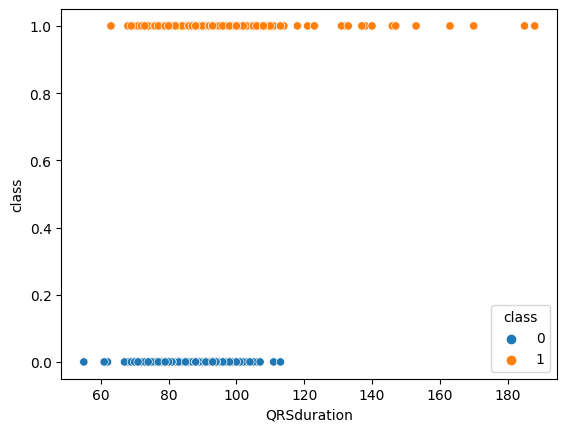

In [23]:
sns.scatterplot(data=df, hue="class", x="QRSduration", y="class")

## Teste ANOVA

In [25]:
from sklearn.feature_selection import f_classif

In [26]:
f_classif(X_ohoe['QRSduration'].values.reshape((-1,1)), y)

(array([54.66233399]), array([7.04342399e-13]))

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 54  69 116 117 122 125 128 137 138 154 178 214 220 227 267 327 337] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


<Axes: ylabel='Count'>

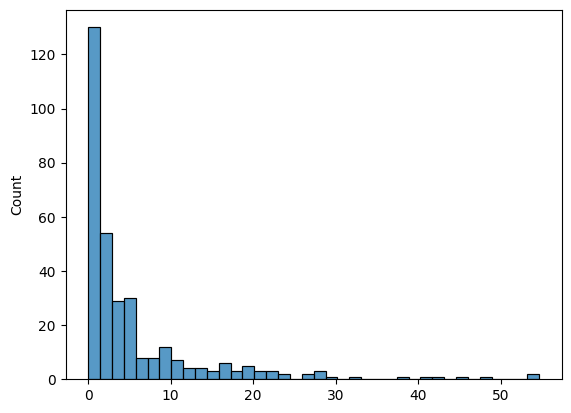

In [27]:
sns.histplot(f_classif(ctimp.fit_transform(X_ohoe), y)[0])

In [28]:
from sklearn.feature_selection import SelectPercentile

In [29]:
for decil in (np.arange(10)*10)[1:]:
    print("decil: %d" % (decil))
    sp = SelectPercentile(f_classif, percentile=decil)
    for nome, classificador, scale, params in testes:
        nome = "%s_an (%d%%)" % (nome, decil)
        print("Executando teste %s" % (nome))
        r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, sp, params)
        resultados[nome] = r

decil: 10
Executando teste svm_an (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 20
Executando teste svm_an (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 30
Executando teste svm_an (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 40
Executando teste svm_an (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 50
Executando teste svm_an (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 60
Executando teste svm_an (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 70
Executando teste svm_an (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 80
Executando teste svm_an (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

decil: 90
Executando teste svm_an (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste knn_an (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

Executando teste rf_an (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  54  57  66  68  82  83 130 131 138 140 142 144 150 155 156 163
 193 203 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Aprendizagem de Máquina/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  20  66  68  82 126 130 131 138 140 142 143 144 150 155 156 163 203
 253 263 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/dados/juliano/Dropbox/UTFPR/Aulas/AM36O - Apre

In [30]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, alpha=0.05, cols=["knn", "rf", "svm"])

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_an (10%) - Resultados: 0.62 +- 0.10, min: 0.46, max: 0.75
knn_an (20%) - Resultados: 0.61 +- 0.08, min: 0.42, max: 0.72
knn_an (30%) - Resultados: 0.63 +- 0.08, min: 0.51, max: 0.76
knn_an (40%) - Resultados: 0.56 +- 0.14, min: 0.32, max: 0.74
knn_an (50%) - Resultados: 0.52 +- 0.14, min: 0.28, max: 0.69
knn_an (60%) - Resultados: 0.56 +- 0.09, min: 0.39, max: 0.69
knn_an (70%) - Resultados: 0.55 +- 0.09, min: 0.41, max: 0.67
knn_an (80%) - Resultados: 0.54 +- 0.12, min: 0.32, max: 0.67
knn_an (90%) - Resultados: 0.49 +- 0.09, min: 0.36, max: 0.58
  knn_vt=0 - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (10%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (20%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (30%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (40%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd (50%) - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_vtd

## Informação mútua

In [31]:
from sklearn.feature_selection import mutual_info_classif

In [32]:
mutual_info_classif(X_ohoe['QRSduration'].values.reshape((-1,1)), y)

array([0.05994277])

<Axes: ylabel='Count'>

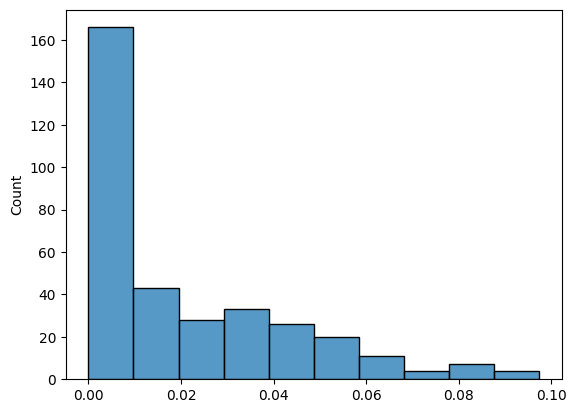

In [33]:
sns.histplot(mutual_info_classif(ctimp.fit_transform(X_ohoe), y))

In [34]:
for decil in (np.arange(10)*10)[1:]:
    print("decil: %d" % (decil))
    sp = SelectPercentile(mutual_info_classif, percentile=decil)
    for nome, classificador, scale, params in testes:
        nome = "%s_mi (%d%%)" % (nome, decil)
        print("Executando teste %s" % (nome))
        r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, sp, params)
        resultados[nome] = r

decil: 10
Executando teste svm_mi (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (10%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 20
Executando teste svm_mi (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (20%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 30
Executando teste svm_mi (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (30%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 40
Executando teste svm_mi (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (40%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 50
Executando teste svm_mi (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (50%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 60
Executando teste svm_mi (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (60%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 70
Executando teste svm_mi (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (70%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 80
Executando teste svm_mi (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (80%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

decil: 90
Executando teste svm_mi (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_mi (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_mi (90%)


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, alpha=0.05, cols=["knn", "rf", "svm"])

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_an (10%) - Resultados: 0.62 +- 0.10, min: 0.46, max: 0.75
knn_an (20%) - Resultados: 0.61 +- 0.08, min: 0.42, max: 0.72
knn_an (30%) - Resultados: 0.63 +- 0.08, min: 0.51, max: 0.76
knn_an (40%) - Resultados: 0.56 +- 0.14, min: 0.32, max: 0.74
knn_an (50%) - Resultados: 0.52 +- 0.14, min: 0.28, max: 0.69
knn_an (60%) - Resultados: 0.56 +- 0.09, min: 0.39, max: 0.69
knn_an (70%) - Resultados: 0.55 +- 0.09, min: 0.41, max: 0.67
knn_an (80%) - Resultados: 0.54 +- 0.12, min: 0.32, max: 0.67
knn_an (90%) - Resultados: 0.49 +- 0.09, min: 0.36, max: 0.58
knn_mi (10%) - Resultados: 0.60 +- 0.09, min: 0.37, max: 0.75
knn_mi (20%) - Resultados: 0.57 +- 0.06, min: 0.50, max: 0.69
knn_mi (30%) - Resultados: 0.56 +- 0.08, min: 0.41, max: 0.67
knn_mi (40%) - Resultados: 0.57 +- 0.11, min: 0.33, max: 0.79
knn_mi (50%) - Resultados: 0.52 +- 0.12, min: 0.27, max: 0.74
knn_mi (60%) - Resultados: 0.56 +- 0.10, min: 0.35, max: 0.71
knn_mi (70

# Usando múltiplos métodos de seleção de características em sequência